Save Gdrive



In [ ]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
#gatien
my_local_drive='/content/gdrive/MyDrive/M1/Projet/donnees'
#gaby
# my_local_drive='/content/gdrive/My Drive/M1_IASD/Colab Notebooks/ML/Projet/donnees/'
sys.path.append(my_local_drive)


# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls

/content/gdrive/MyDrive/M1/Projet/donnees
HAI817_Projet_test.csv     HAI817_Projet_train.csv
HAI817_Projet_test.gsheet  Projet_HAI817I.ipynb


## **Travaux pratiques**

Importer les différentes choses qu'on a besoin

In [ ]:
# Librairie a installer

!pip install langdetect 
!pip install contractions

# Importation des différentes librairies utiles pour le notebook

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np 
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


# Importation des différentes librairies utiles pour le notebook ingenieurie logicielle des données textuelles

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
from scipy.stats import randint
import string
import time
import base64
import re

import contractions

# librairie BeautifulSoup
from bs4 import BeautifulSoup

# librairie affichage
import wordcloud

## detection de language
import langdetect 

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk import RegexpParser
# il est possible de charger l'ensemble des librairies en une seule fois 
# décocher le commentaire de la ligne ci-dessous
#nltk.download('all') 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
nltk.download('tagsets')
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords

import spacy
from spacy.tokens import Span
from spacy.lang.fr import French

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


On récupère les infos du dataset

In [ ]:
df=pd.read_csv('HAI817_Projet_test.csv')

FileNotFoundError: ignored

Afficher le nombre de ligne et de colonnes du dataframe ainsi que les 5 premières lignes

In [ ]:
print(f"lignes : {df.shape[0]}, colonnes : {df.shape[1]}")

df.head(5)

lignes : 612, colonnes : 4


,ID,text,title,our rating
0,122653045997905671927713471889615536378,The deputy secretary at the US Treasury has sa...,US Treasury deputy sec warns that shortages li...,mixture
1,275389285957305997321446227088442471741,KABUL—Approximately twelve minutes after U.S. ...,CNN Praises Taliban For Wearing Masks During A...,other
2,333248764296609831067233855420575814716,The vast majority of (oblivious) Americans hav...,Tennessee Has Just LEGALIZED Government COVID ...,false
3,264019763253447756851916399533799891538,(Natural News) There’s a secret layer of infor...,MEDICAL SHOCKER: Scientists at Sloan Kettering...,false
4,158073737187690682830899773280916034317,"A recent study reported by the NCBI, which is ...",Study Results: Facemasks are Ineffective to Bl...,false


Afficher la matrice de corrélation. Rappel il faut utiliser la fonction corr().

In [ ]:
corr = df.corr()
display(corr)

test12

NameError: ignored

Afficher, à l'aide de seaborn, la matrice de correlation

<AxesSubplot:>

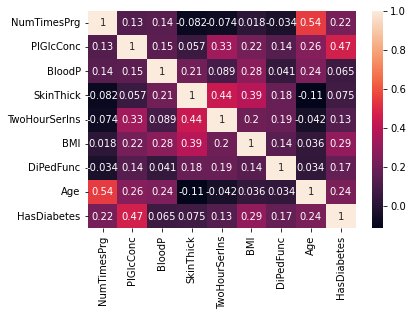

In [ ]:
sns.heatmap(corr, annot = True)

Il est important d'analyser les histogrammes de chaque variable pour mieux comprendre comment les données sont réparties.  
A l'aide du code suivant, afficher les différents histogrammes.  
import matplotlib.pyplot as plt  
df.hist(bins=50, figsize=(20, 15))  
plt.show()  

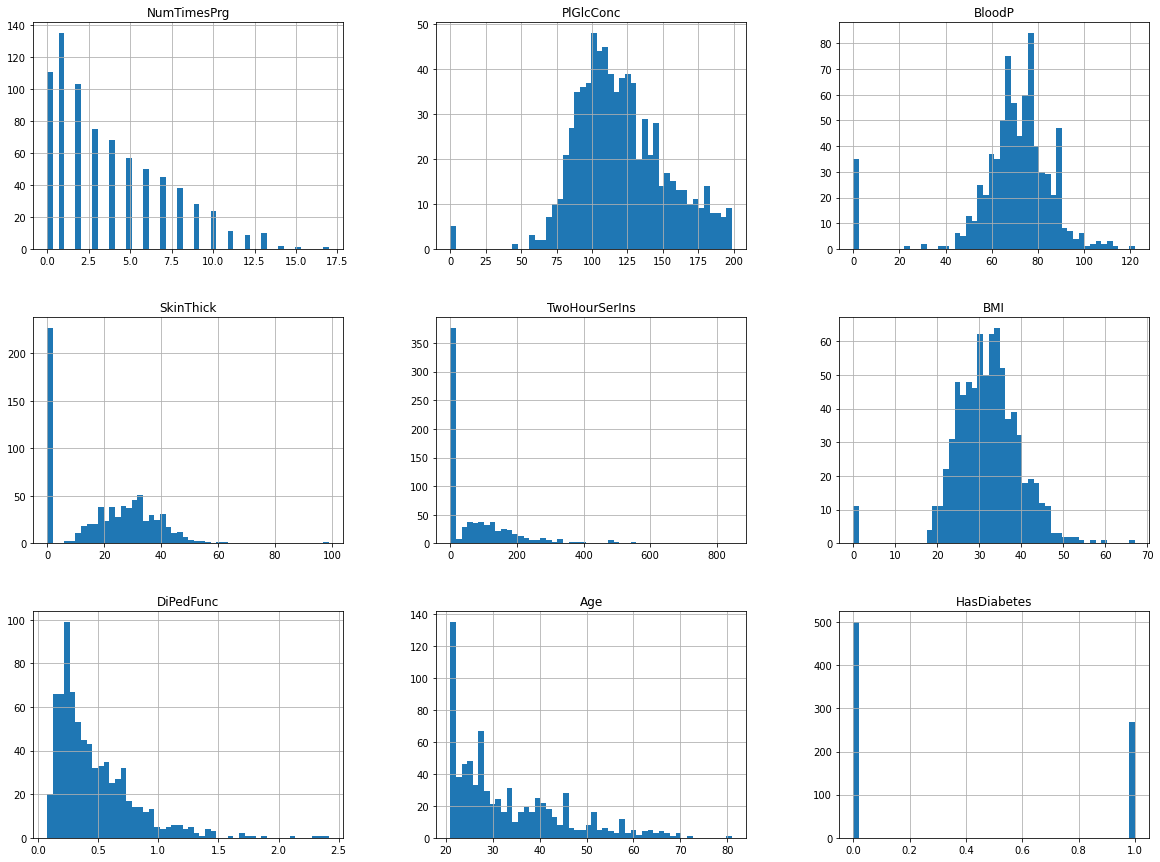

In [ ]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

<AxesSubplot:>

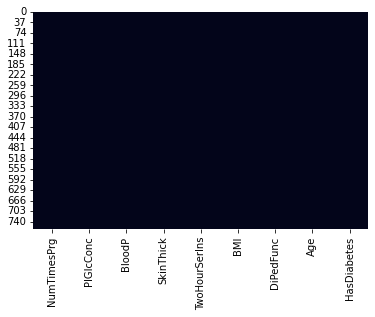

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

Existe-t'il des valeurs nulles ? Existe-til des valeurs manquantes ? Rappel vous pouvez le voir avec des histogrammes mais aussi avec une heatmap.  

En fait on peut constater qu'il n'y a pas de valeurs manquantes avec le heatmap mais par contre il y a des valeurs nulles. Il faut toujours faire attention à la manière dont sont codées les valeurs manquantes. Ici nous voyons dans les histogrammes que pour BMI, BloodP, PlGlcConc, SkinThick, TwoHourSerIns il existe des valeurs manquantes. Le nombre de grossesses n'est pas considéré comme une valeur manquante bien sûr.  

Transformer les valeurs nulles par la médiane de la série. 

In [ ]:
# valeur médiane
median_bmi = df['BMI'].median()
# remplacement par la médiane
df['BMI'] = df['BMI'].replace(
 to_replace=0, value=median_bmi)

# valeur médiane
median_bloodP = df['BloodP'].median()
# remplacement par la médiane
df['BloodP'] = df['BloodP'].replace(
 to_replace=0, value=median_bloodP)

# valeur médiane
median_PlGlcConc = df['PlGlcConc'].median()
# remplacement par la médiane
df['PlGlcConc'] = df['PlGlcConc'].replace(
 to_replace=0, value=median_PlGlcConc)

# valeur médiane
median_SkinThick = df['SkinThick'].median()
# remplacement par la médiane
df['SkinThick'] = df['SkinThick'].replace(
 to_replace=0, value=median_SkinThick)

# valeur médiane
median_TwoHourSerIns = df['TwoHourSerIns'].median()
# remplacement par la médiane
df['TwoHourSerIns'] = df['TwoHourSerIns'].replace(
 to_replace=0, value=median_TwoHourSerIns)

Les données sont, à présent, transformées et nous allons pouvoir créer un jeu de données de test et d'apprentissage. Faire une copie du dataframe en df2. Sur df appliquer un scaling pour normaliser les valeurs par rapport à la moyenne et l'écart type (utilisation de StandardScaler (). Nous conservons la copie df2 sans transformation.   
L'objectif à présent est d'appliquer différents classifieurs pour voir celui qui est le plus performant. Pour le ou les meilleurs rechercher les hyperparamètres et créer un pipeline à sauvegarder. Il faut ensuite pouvoir traiter de nouvelles données pour prédire si il y a diabète ou pas.  

Tester les résultats sur df et sur df2. 

In [ ]:
# pour essayer sans scaling
df2=df.copy()

#traitement de df
# séparation données à prédire
array = df2.values
X = array[:,0:8]
y = array[:,8]

#utilisation de StandardScaler
standardscaler = StandardScaler()
X = standardscaler.fit_transform(X)
print ("Pour vérifier que les données ont bien été transformées")
print (pd.DataFrame(X).head())


#création d'un jeu de test et d'apprentissage (70,30)
from sklearn.model_selection import train_test_split
validation_size=0.3 #30% du jeu de données pour le test
testsize = (1-validation_size)
seed = 30
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=validation_size,
                                                    random_state=seed,
                                                    test_size=testsize)

Pour vérifier que les données ont bien été transformées
          0         1         2         3         4         5         6  \
0  0.639947  0.848324  0.149641  0.907270 -0.692891  0.204013  0.468492   
1 -0.844885 -1.123396 -0.160546  0.530902 -0.692891 -0.684422 -0.365061   
2  1.233880  1.943724 -0.263941 -1.288212 -0.692891 -1.103255  0.604397   
3 -0.844885 -0.998208 -0.160546  0.154533  0.123302 -0.494043 -0.920763   
4 -1.141852  0.504055 -1.504687  0.907270  0.765836  1.409746  5.484909   

          7  
0  1.425995  
1 -0.190672  
2 -0.105584  
3 -1.041549  
4 -0.020496  
